# electronic-gadget-identifier
Machine learning project that identifies different electronic gadgets

* Jesse Båtman (TT2018-3A) - e1700826
* Joonatan Peltonen (TT2018-3B) - e1700807

In [1]:
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
from time import time
from torchvision import datasets, transforms, models
from torch import nn, optim

In [2]:
pretrained_size = 256
pretrained_means = [0.485, 0.456, 0.406]
pretrained_stds= [0.229, 0.224, 0.225]

transform = transforms.Compose([
                                transforms.Resize(pretrained_size),
                                transforms.CenterCrop(224),
                                transforms.ToTensor(),
                                transforms.Normalize(mean = pretrained_means, std = pretrained_stds)
                              ])

In [3]:
trainset = datasets.ImageFolder(r'datasets\training', transform=transform)
validationset = datasets.ImageFolder(r'datasets\validation', transform=transform)

In [4]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
validationloader = torch.utils.data.DataLoader(validationset, batch_size=64, shuffle=True)

In [5]:
dataiter = iter(trainloader)
images, labels = dataiter.next()

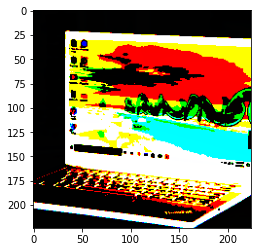

In [6]:
plt.imshow(images[1].permute(1, 2, 0).numpy().astype(np.uint8))

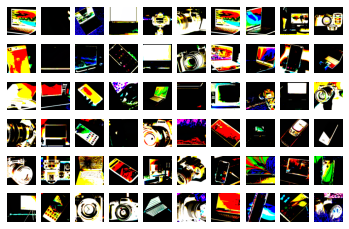

In [7]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].permute(1, 2, 0).numpy().astype(np.uint8))

In [8]:
import torchvision.models as models

pretrained_model = models.vgg16_bn(pretrained = True)

print(pretrained_model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

In [9]:
classification_layer = nn.Sequential(nn.Linear(25088, 4096), 
                                     nn.ReLU(),
                                     nn.Dropout(p=0.3),
                                     nn.Linear(4096, 4),
                                     nn.LogSoftmax(dim=1))

pretrained_model.classifier =  classification_layer

print(pretrained_model.classifier)
model = pretrained_model

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.3, inplace=False)
  (3): Linear(in_features=4096, out_features=4, bias=True)
  (4): LogSoftmax(dim=1)
)


In [10]:
criterion = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
torch.set_num_threads(8)

In [11]:
def run_conf_features(datasetloader):
    conv_features = []
    labels_list = []

    for images, labels in datasetloader:
        model.eval()
        with torch.no_grad():
            # modeling for each image batch
            conv_layer_output = model.features(images)        

            # flatten output as the next layers are the fully connected layers
            output = conv_layer_output.view(conv_layer_output.size(0), -1)

            conv_features.extend(output.data.cpu().numpy())
            labels_list.extend(labels.data.cpu().numpy())
            
    return (torch.Tensor(conv_features), torch.LongTensor(labels_list))

In [12]:
conv_features, labels_list = run_conf_features(trainloader)

In [13]:
conv_features_dataset = torch.utils.data.TensorDataset(conv_features, labels_list)
trainloader = torch.utils.data.DataLoader(conv_features_dataset, batch_size=64, shuffle=True)

In [14]:
conv_features, labels_list = run_conf_features(validationloader)

In [15]:
conv_features_dataset = torch.utils.data.TensorDataset(conv_features, labels_list)
validationloader = torch.utils.data.DataLoader(conv_features_dataset, batch_size=64, shuffle=True)

In [16]:
time0 = time()
epochs = 6

# For plotting the model quality metrics.
epoch_list = []
training_loss_list = []
training_acc_list = []
validation_loss_list = []
validation_acc_list = []

for e in range(epochs):
    running_loss = 0
    # Variables to store the new quality metrics
    training_acc = 0
    validation_loss = 0
    validation_acc = 0
    for images, labels in trainloader:
        model.train()
        # CNN: flattening is not needed anymore, we expect 2d image.

        # defining gradient in each epoch as 0
        optimizer.zero_grad()
        
        output = model.classifier(images)
        
        # calculating the loss
        loss = criterion(output, labels)
        
        # This is where the model learns by backpropagating
        loss.backward()
        
        # And optimizes its weights here
        optimizer.step()
        
        # calculating the loss
        running_loss += loss.item()
        
        
        # Calculate training accuracy
        with torch.no_grad():
            # Output of the network are log-probabilities, need to take exponential for probabilities
            _, predictions = torch.exp(output).max(1)
            # Match predictions with true labels and count how many predictions are correct.
            # Divide by batch size to get average for this batch.
            training_acc += torch.sum(predictions == labels).item() / len(images)            

    # Calculate validation loss and accuracy
    for images, labels in validationloader:
        with torch.no_grad():
            model.eval()
            # CNN: flattening is not needed anymore, we expect 2d image.

            # modeling for each image batch
            output = model.classifier(images)

            # calculating the loss
            loss = criterion(output, labels)

            # calculating the loss
            validation_loss += loss.item()

            # Output of the network are log-probabilities, need to take exponential for probabilities
            _, predictions = torch.exp(output).max(1)
            # Match predictions with true labels and count how many predictions are correct.
            # Divide by batch size to get average for this batch.
            validation_acc += torch.sum(predictions == labels).item() / len(images)

    print(
        "Epoch {} - Elapsed minutes {} - Train loss: {:0.5f}  Train acc: {:0.5f} Val loss: {:0.5f} Val acc: {:0.5f}"
        .format(
            e,
            (time()-time0)/60,
            running_loss/len(trainloader),
            training_acc/len(trainloader),
            validation_loss/len(validationloader),
            validation_acc/len(validationloader)
        )
    )
    
    epoch_list.append(e);
    training_loss_list.append(running_loss/len(trainloader))
    training_acc_list.append(training_acc/len(trainloader))
    validation_loss_list.append(validation_loss/len(validationloader))
    validation_acc_list.append(validation_acc/len(validationloader))

print("\nTraining Time (in minutes) =",(time()-time0)/60)

Epoch 0 - Elapsed minutes 0.024108386039733885 - Train loss: 1.20476  Train acc: 0.57031 Val loss: 0.79433 Val acc: 0.86315
Epoch 1 - Elapsed minutes 0.05217504103978475 - Train loss: 0.55990  Train acc: 0.97656 Val loss: 0.35497 Val acc: 0.95770
Epoch 2 - Elapsed minutes 0.08217504421869913 - Train loss: 0.20843  Train acc: 0.97266 Val loss: 0.16026 Val acc: 0.95851
Epoch 3 - Elapsed minutes 0.11394172112147014 - Train loss: 0.09111  Train acc: 0.98047 Val loss: 0.08819 Val acc: 0.98357
Epoch 4 - Elapsed minutes 0.14604169925053914 - Train loss: 0.03885  Train acc: 0.99219 Val loss: 0.07903 Val acc: 0.98357
Epoch 5 - Elapsed minutes 0.17695003747940063 - Train loss: 0.02123  Train acc: 1.00000 Val loss: 0.07991 Val acc: 0.98357

Training Time (in minutes) = 0.1769583781560262


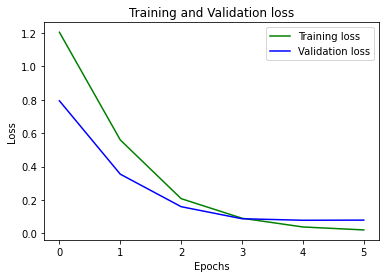

In [17]:
plt.plot(epoch_list, training_loss_list, 'g', label='Training loss')
plt.plot(epoch_list, validation_loss_list, 'b', label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

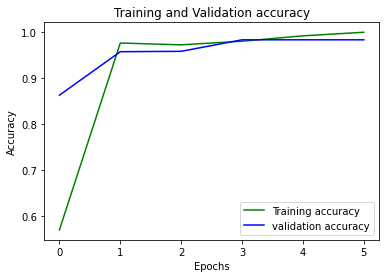

In [18]:
plt.plot(epoch_list, training_acc_list, 'g', label='Training accuracy')
plt.plot(epoch_list, validation_acc_list, 'b', label='validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [19]:
torch.save(model, 'model.pt')

In [20]:
from PIL import Image

model = torch.load('model.pt')

In [21]:
def predict(image):
    transformed = transform(image)

    with torch.no_grad():
        logpb = model(transformed.view(1,3,224,224))
        
    _, predictions = torch.exp(logpb).max(1)
    
    if predictions == 2:
        return 'Phone'
    elif predictions == 0:
        return 'Camera'
    elif predictions == 1:
        return 'Laptop'
    elif predictions == 3:
        return 'TV'
    else:
        return 'Unkown'


Phone


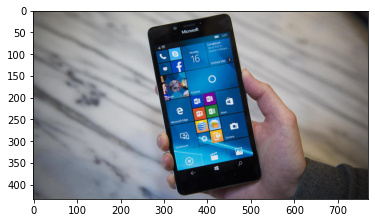

In [22]:
image=Image.open(r'datasets\testing\phone_001.jpg')
plt.imshow(image)
print(predict(image))

Phone


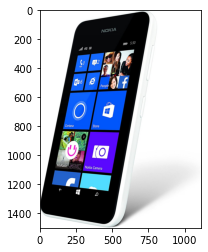

In [23]:
image=Image.open(r'datasets\testing\phone_002.jpg')
plt.imshow(image)
print(predict(image))

Laptop


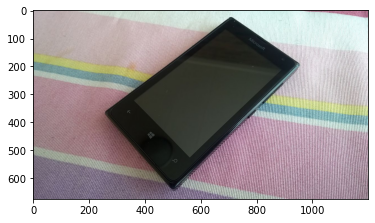

In [24]:
image=Image.open(r'datasets\testing\phone_003.jpg')
plt.imshow(image)
print(predict(image))

TV


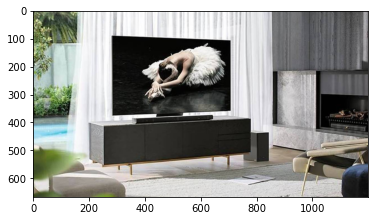

In [25]:
image=Image.open(r'datasets\testing\tv_001.jpg')
plt.imshow(image)
print(predict(image))

TV


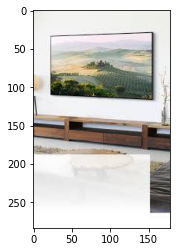

In [26]:
image=Image.open(r'datasets\testing\tv_002.jpg')
plt.imshow(image)
print(predict(image))

TV


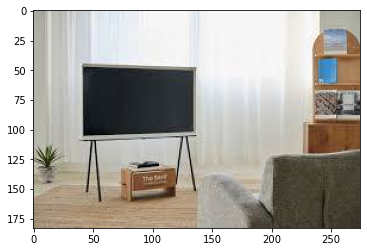

In [27]:
image=Image.open(r'datasets\testing\tv_003.jpg')
plt.imshow(image)
print(predict(image))

Laptop


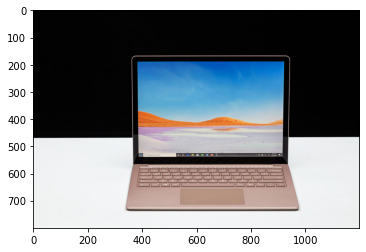

In [28]:
image=Image.open(r'datasets\testing\laptop_001.jpg')
plt.imshow(image)
print(predict(image))

Laptop


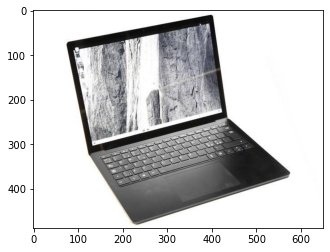

In [29]:
image=Image.open(r'datasets\testing\laptop_002.jpg')
plt.imshow(image)
print(predict(image))

Laptop


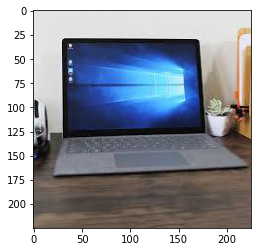

In [30]:
image=Image.open(r'datasets\testing\laptop_003.jpg')
plt.imshow(image)
print(predict(image))

Camera


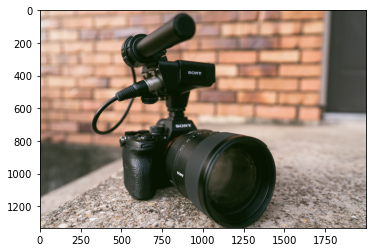

In [31]:
image=Image.open(r'datasets\testing\camera_001.jpg')
plt.imshow(image)
print(predict(image))

Camera


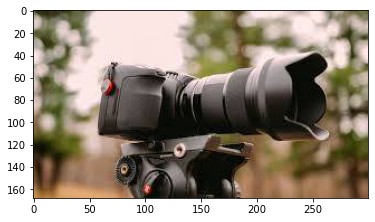

In [32]:
image=Image.open(r'datasets\testing\camera_002.jpg')
plt.imshow(image)
print(predict(image))

Camera


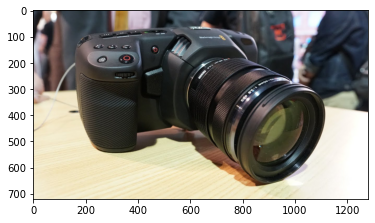

In [33]:
image=Image.open(r'datasets\testing\camera_003.jpg')
plt.imshow(image)
print(predict(image))